In [ ]:
import scanpy as sc
import pandas as pd
import numpy as np
from pyfaidx import Fasta
from verstack import stratified_continuous_split
import matplotlib.pyplot as plt
import time

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_error
from sklearn.metrics import f1_score
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
import scipy
from scipy import stats
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch import Tensor
from torch.utils.data import TensorDataset, DataLoader
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import Dataset
from torchvision import datasets
from torcheval.metrics.functional import multiclass_f1_score

import h5py
import seaborn as sns
import os
os.chdir('/nfs/public/xixi/scRegulate/SHAREseq')

from typing import Tuple

# Data preprocess

In [2]:
df_x = pd.read_csv('atac.aggregate_30cells.csv', index_col=0).transpose()
df_x

,chr18-31634804-31635104,chr1-165460961-165461261,chr1-75317415-75317715,chr18-46525819-46526119,chr4-3938558-3938858,chr6-71440583-71440883,chr7-105399959-105400259,chr1-161876704-161877004,chr6-113306525-113306825,chr1-177796516-177796816,...,chr10-111689260-111689560,chr10-111388777-111389077,chr10-110841761-110842061,chr10-10884983-10885283,chr10-108335612-108335912,chr10-107887768-107888068,chr10-107038880-107039180,chr10-10549625-10549925,chr10-105270865-105271165,chr10-103291333-103291633
V1,2.112241,1.988862,1.988862,1.664337,1.758608,2.112241,1.758608,1.434083,1.919221,1.919221,...,0.0,0.000000,0.0,0.0,0.554779,0.0,0.0,0.000000,0.0,0.0
V2,2.184422,2.079218,1.957768,1.533112,1.814123,1.889215,1.957768,1.814123,1.731114,1.814123,...,0.0,0.000000,0.0,0.0,0.546106,0.0,0.0,0.000000,0.0,0.0
V3,2.381858,1.865213,1.717455,1.542694,2.298454,1.542694,2.298454,1.993207,1.865213,1.865213,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0
V4,2.296301,1.952485,1.863144,1.952485,1.364729,2.107085,1.763270,1.952485,1.863144,2.174958,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0
V5,2.021073,1.682703,1.763392,1.903019,1.763392,1.836383,1.682703,1.763392,1.490239,1.490239,...,0.0,0.000000,0.0,0.0,0.841352,0.0,0.0,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
V839,3.323174,3.171114,3.171114,2.585932,2.322799,2.585932,3.323174,2.585932,2.000750,2.808408,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,1.000375,0.0,0.0
V840,2.806491,2.806491,2.055718,2.656048,2.656048,2.485490,1.770699,2.055718,2.806491,2.288595,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0
V841,2.915099,1.888067,1.626292,2.101953,2.577613,1.888067,2.282790,1.626292,2.439439,2.282790,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.813146,0.0,0.0
V842,1.385682,1.421908,1.021733,1.209012,1.346771,1.385682,1.487627,1.259056,1.346771,1.385682,...,0.0,0.363949,0.0,0.0,0.000000,0.0,0.0,0.363949,0.0,0.0


In [3]:
df_y = pd.read_csv('rna.aggregate_30cells.csv', index_col=0).transpose()
df_y

,0610009B22Rik,0610009L18Rik,0610010F05Rik,0610010K14Rik,0610012D04Rik,0610012G03Rik,0610025J13Rik,0610030E20Rik,0610038B21Rik,0610039K10Rik,...,mt-Co2,mt-Co3,mt-Cytb,mt-Nd1,mt-Nd2,mt-Nd3,mt-Nd4,mt-Nd4l,mt-Nd5,mt-Nd6
V1,0.0,0.000000,1.179400,0.000000,0.0,0.000000,0.0,0.589700,0.000000,0.0,...,0.0,0.0,2.629728,2.459005,1.869305,0.0,1.369241,0.0,2.667545,1.655498
V2,0.0,0.000000,1.547446,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,...,0.0,0.0,2.191146,1.849178,1.713501,0.0,1.547446,0.0,2.063261,1.333363
V3,0.0,0.581185,1.162371,0.581185,0.0,0.000000,0.0,0.000000,0.581185,0.0,...,0.0,0.0,2.468833,2.591756,2.270628,0.0,1.930656,0.0,2.511841,1.842314
V4,0.0,0.000000,1.265819,0.000000,0.0,0.000000,0.0,1.003138,0.000000,0.0,...,0.0,0.0,2.822417,2.409712,1.776802,0.0,2.102480,0.0,2.688554,2.006276
V5,0.0,0.000000,0.897976,0.000000,0.0,0.566560,0.0,0.566560,0.566560,0.0,...,0.0,0.0,2.526534,2.266239,2.157094,0.0,1.882071,0.0,2.448630,1.699679
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
V839,0.0,0.000000,1.287068,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,...,0.0,0.0,2.039954,3.861204,2.574136,0.0,2.574136,0.0,4.275547,2.039954
V840,0.0,0.000000,0.502798,0.000000,0.0,0.000000,0.0,0.502798,0.000000,0.0,...,0.0,0.0,1.670258,1.670258,1.167460,0.0,1.593831,0.0,2.208447,1.299713
V841,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,...,0.0,0.0,2.453196,2.113068,2.113068,0.0,1.674567,0.0,3.787635,0.000000
V842,0.0,0.000000,0.932346,0.000000,0.0,0.000000,0.0,0.571665,0.360681,0.0,...,0.0,0.0,1.558835,1.608430,1.247750,0.0,1.143330,0.0,1.733919,0.837474


In [4]:
df_peaks = pd.DataFrame(df_x.columns)[0].str.split('-',expand=True) 
df_peaks = df_peaks.rename(columns={0: "chrom", 1: "start", 2: "end"})
df_peaks["start"] = pd.to_numeric(df_peaks["start"])
df_peaks["end"] = pd.to_numeric(df_peaks["end"])
df_peaks

,chrom,start,end
0,chr18,31634804,31635104
1,chr1,165460961,165461261
2,chr1,75317415,75317715
3,chr18,46525819,46526119
4,chr4,3938558,3938858
...,...,...,...
338699,chr10,107887768,107888068
338700,chr10,107038880,107039180
338701,chr10,10549625,10549925
338702,chr10,105270865,105271165


In [5]:
#df_peaks.to_csv('/data1/xixi/scRegulate/multiomic_data/10x_PBMC/peaks_all.csv')

In [6]:
geneanno = pd.read_csv('../../ref_genome/mm10_geneanno.txt', sep='\t')
geneanno = geneanno.drop_duplicates(subset=['Gene name'])
geneanno

,Gene stable ID,Gene stable ID version,Chromosome/scaffold name,Gene start (bp),Gene end (bp),Strand,Gene name,Source of gene name,Transcription start site (TSS)
0,ENSMUSG00000070103,ENSMUSG00000070103.2,1,158505625,158505733,1,Mir488,MGI Symbol,158505625
1,ENSMUSG00000065567,ENSMUSG00000065567.1,1,23291701,23291784,1,Mir30c-2,MGI Symbol,23291701
2,ENSMUSG00000094946,ENSMUSG00000094946.1,1,83795912,83796032,1,Gm25754,MGI Symbol,83795912
3,ENSMUSG00000093155,ENSMUSG00000093155.1,1,74586896,74586972,-1,Gm25035,MGI Symbol,74586972
4,ENSMUSG00000065458,ENSMUSG00000065458.1,1,137966639,137966718,1,Mir181b-1,MGI Symbol,137966639
...,...,...,...,...,...,...,...,...,...
103991,ENSMUSG00000099633,ENSMUSG00000099633.1,Y,84907473,84910700,1,Gm29071,MGI Symbol,84907473
103993,ENSMUSG00000100388,ENSMUSG00000100388.1,Y,50770044,50773283,1,Gm29116,MGI Symbol,50770044
103995,ENSMUSG00000091987,ENSMUSG00000091987.8,Y,2900989,2912206,1,Gm10352,MGI Symbol,2900989
103997,ENSMUSG00000101667,ENSMUSG00000101667.1,Y,2932582,2939416,1,Gm29289,MGI Symbol,2932582


# Prepare data

In [7]:
motif_files = os.listdir('../../ref_genome/JASPAR_motifs_pfm_mouse/pfm.np')
motif_files[:5]

['MA0002.2.Runx1.npy',
 'MA0006.1.Ahr::Arnt.npy',
 'MA0004.1.Arnt.npy',
 'MA0007.3.Ar.npy',
 'MA0009.1.Tbxt.npy']

In [8]:
tfs_kept = []
tf_by_region_mat = []
for i in list(motif_files):
    tf = i.split('.')[-2].capitalize()
    if tf in df_y.columns:
        if tf in tfs_kept:
            continue
            
        tfs_kept.append(tf)
tfs_kept = sorted(tfs_kept)

In [9]:
go = pd.read_csv('./go/go_follicle.txt', sep='\t')
go

,id1,name,namespace,def,relation,id2
0,GO:0031069,hair follicle morphogenesis,biological_process,The process in which the anatomical structures...,part_of,GO:0001942
1,GO:0048820,hair follicle maturation,biological_process,"A developmental process, independent of morpho...",part_of,GO:0001942
2,GO:0051797,regulation of hair follicle development,biological_process,"Any process that modulates the frequency, rate...",regulates,GO:0001942
3,GO:0051798,positive regulation of hair follicle development,biological_process,Any process that activates or increases the fr...,positively_regulates,GO:0001942
4,GO:0051799,negative regulation of hair follicle development,biological_process,"Any process that stops, prevents, or reduces t...",negatively_regulates,GO:0001942
5,GO:0060789,hair follicle placode formation,biological_process,The developmental process in which a hair plac...,part_of,GO:0001942
6,GO:0042637,catagen,biological_process,The regression phase of the hair cycle during ...,part_of,GO:0048820
7,GO:0042640,anagen,biological_process,"The growth phase of the hair cycle. Lasts, for...",part_of,GO:0048820
8,GO:0051798,positive regulation of hair follicle development,biological_process,Any process that activates or increases the fr...,is_a,GO:0051797
9,GO:0051799,negative regulation of hair follicle development,biological_process,"Any process that stops, prevents, or reduces t...",is_a,GO:0051797


In [10]:
goa = pd.read_csv('./go/goa_follicle.txt', sep='\t')
goa

,X0,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14,X15,X16
0,MGI,MGI:108359,Alx4,involved_in,GO:0001942,MGI:MGI:4834177|GO_REF:0000096,ISO,UniProtKB:Q9H161,P,aristaless-like homeobox 4,Aristaless-like 4,protein_coding_gene,taxon:10090,20100901,MGI,NaN,NaN
1,MGI,MGI:3513977,Apcdd1,involved_in,GO:0001942,MGI:MGI:4834177|GO_REF:0000096,ISO,UniProtKB:Q8J025,P,adenomatosis polyposis coli down-regulated 1,Drapc1|EIG180,protein_coding_gene,taxon:10090,20100423,MGI,NaN,NaN
2,MGI,MGI:88138,Bcl2,involved_in,GO:0031069,MGI:MGI:63353|PMID:8402909,IMP,NaN,P,B cell leukemia/lymphoma 2,Bcl-2|C430015F12Rik|D830018M01Rik,protein_coding_gene,taxon:10090,20070305,UniProt,NaN,NaN
3,MGI,MGI:2443583,Fermt1,involved_in,GO:0051886,MGI:MGI:5571208|PMID:24681597,IMP,NaN,P,fermitin family member 1,5830467P10Rik|Kindlin-1,protein_coding_gene,taxon:10090,20161121,CAFA,NaN,NaN
4,MGI,MGI:102949,Foxn1,involved_in,GO:0051798,MGI:MGI:5437206|PMID:21109991,IMP,NaN,P,forkhead box N1,D11Bhm185e|Hfh11|whn,protein_coding_gene,taxon:10090,20150111,UniProt,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176,MGI,MGI:99400,Atp7a,acts_upstream_of_or_within,GO:0031069,PMID:2473662,IMP,MGI:MGI:1856466,P,"ATPase, Cu++ transporting, alpha polypeptide",Menkes protein|MNK|br,protein_coding_gene,taxon:10090,20061107,MGI,NaN,NaN
177,MGI,MGI:99560,Hoxc13,acts_upstream_of_or_within,GO:0001942,PMID:21191399,IMP,MGI:MGI:1926422,P,homeobox C13,N,protein_coding_gene,taxon:10090,20121227,MGI,NaN,NaN
178,MGI,MGI:99560,Hoxc13,acts_upstream_of_or_within,GO:0001942,PMID:9420327,IMP,MGI:MGI:1926422,P,homeobox C13,N,protein_coding_gene,taxon:10090,20080322,MGI,results_in_development_of(EMAPA:26747),NaN
179,MGI,MGI:99560,Hoxc13,acts_upstream_of_or_within,GO:0001942,PMID:9420327,IMP,MGI:MGI:1926422,P,homeobox C13,N,protein_coding_gene,taxon:10090,20080322,MGI,results_in_development_of(EMAPA:36498),NaN


# Data preparation for nn

In [11]:
files = os.listdir('/nfs/public/xixi/scRegulate/SHAREseq/nn.best.feature6.learnW_go')
markers_filtered = []
for file in files:
    marker = file.split('.')[0]
    if marker not in markers_filtered:
        markers_filtered.append(marker)
len(markers_filtered)

77

In [12]:
genes = goa['X2'].drop_duplicates().to_list()
print(len(genes))
genes_filtered = [i for i in genes if i not in tfs_kept]
print(len(genes_filtered))
genes_filtered = [i for i in genes_filtered if i in markers_filtered]
print(len(genes_filtered))

113
107
77


In [13]:
goa_filtered = goa.loc[goa['X2'].isin(genes_filtered),]
gos = goa_filtered['X4'].drop_duplicates().to_list()
len(gos)

12

In [14]:
go_filtered = go.loc[go['id1'].isin(gos) & go['id2'].isin(gos),]
len(pd.concat([go_filtered['id1'].drop_duplicates(), go_filtered['id2'].drop_duplicates()]).drop_duplicates())

12

In [15]:
gos = goa_filtered['X4'].drop_duplicates().to_list()
mask = torch.zeros(len(genes_filtered), len(gos))
for i in range(len(goa_filtered['X2'])):
    if goa_filtered['X2'].iloc[i] in genes_filtered:
        mask[genes_filtered.index(goa_filtered['X2'].iloc[i]), gos.index(goa_filtered['X4'].iloc[i])] = 1
mask = mask.t()
mask.shape

torch.Size([12, 77])

In [16]:
W_true = np.zeros((len(gos), len(gos)))
for i in range(len(go_filtered)):
    W_true[gos.index(go_filtered['id1'].iloc[i]), gos.index(go_filtered['id2'].iloc[i])]=1
W_true

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [17]:
h5f = h5py.File('./predict_lineage_pseudotime/data_follicle2.h5', 'r')
X = h5f['X'][:]
expr = h5f['expr'][:]
num_peaks = h5f['num_peaks'][:]
peaks = pd.DataFrame(h5f['num_peaks'][:])
h5f.close()
print(X.shape)
print(expr.shape)
print(num_peaks)

(843, 165, 11058)
(843, 77)
[142 177  60 140 104 156  78 320 256  98 108 205  93 105  73 198 233 209
 158 176 272 187 249 357 167 120 152 119 104 243  39  15 257  32 124   7
 189 308 115  89 138  54  50 157  74 147 145  74 103 136 110 147  50 131
 134 174 173 218 120 146 100  27 119 129 195 153 116  84 140 154 186 132
 205  88 182  71 262]


In [18]:
cut = [0]
s = 0
for i in num_peaks:
    s = s+i
    cut.append(s)
len(cut)

78

In [19]:
y = pd.read_csv('skin.aggregate.cellid&cluster&pseudotime_30cells.csv', index_col=0)
time = np.array(y['aggr_pseudotime'])
y_std = (time - time.min()) / (time.max() - time.min())
y_pseudo = y_std * (1 - (0)) + (0)
y_pseudo = y_pseudo.reshape((len(y), 1))

y = np.array(y['celltype'])
y_new = y.reshape((len(y), 1))
enc = OneHotEncoder(handle_unknown='ignore')
y_oht = enc.fit_transform(y_new).toarray()
for i, category in enumerate(enc.categories_[0]):
    print(f"{category}: {i}")
print(y_oht.shape)
y_oht = np.concatenate([y_oht, y_pseudo], axis=1)
print(y_oht.shape)

0: 0
1: 1
2: 2
3: 3
4: 4
5: 5
(843, 6)
(843, 7)


In [20]:
X_train, X_test, expr_train, expr_test, y_oht_train, y_oht_test, y_train, y_test = train_test_split(X, expr, y_oht, y, test_size=0.3,
                                                                                                    random_state=2023, stratify=y)
X_test, X_val, expr_test, expr_val, y_oht_test, y_oht_val, y_test, y_val = train_test_split(X_test, expr_test, y_oht_test, y_test, 
                                                                                                test_size=0.5, random_state=2023, 
                                                                                            stratify=y_test)
print(X_train.shape)
print(expr_train.shape)
print(y_oht_train.shape)
print(X_val.shape)
print(X_test.shape)

(590, 165, 11058)
(590, 77)
(590, 7)
(127, 165, 11058)
(126, 165, 11058)


In [21]:
use_cuda = True
device = torch.device("cuda:3" if use_cuda else "cpu")


X_train = torch.from_numpy(X_train).float().to(device)
X_val = torch.from_numpy(X_val).float().to(device)
X_test = torch.from_numpy(X_test).float().to(device)
expr_train = torch.from_numpy(expr_train).float().to(device)
expr_val = torch.from_numpy(expr_val).float().to(device)
expr_test = torch.from_numpy(expr_test).float().to(device)
y_train = torch.from_numpy(y_oht_train).float().to(device)
y_val = torch.from_numpy(y_oht_val).float().to(device)
y_test = torch.from_numpy(y_oht_test).float().to(device)
print(X_train.shape)
print(expr_train.shape)
print(y_train.shape)

torch.Size([590, 165, 11058])
torch.Size([590, 77])
torch.Size([590, 7])


# Def

In [22]:
class TensorDataset(Dataset[Tuple[Tensor, ...]]):
    r"""Dataset wrapping tensors.

    Each sample will be retrieved by indexing tensors along the first dimension.

    Args:
        *tensors (Tensor): tensors that have the same size of the first dimension.
    """
    tensors: Tuple[Tensor, ...]

    def __init__(self, *tensors: Tensor) -> None:
        assert all(tensors[0].size(0) == tensor.size(0) for tensor in tensors), "Size mismatch between tensors"
        self.tensors = tensors

    def __getitem__(self, index):
        return tuple(tensor[index] for tensor in self.tensors)

    def __len__(self):
        return self.tensors[0].size(0)

In [23]:
class Net(nn.Module):
    def __init__(self, genes, num_peaks, num_tf, cut, mask, num_gos):
        super(Net, self).__init__()
        self.num_peaks = num_peaks
        self.num_tf = num_tf
        self.genes = genes
        self.cut = cut
        self.mask = mask
        self.num_gos = num_gos
        self.go_dim=6

        self.fc1 = nn.Linear(len(self.genes), 20)
        self.fc1_act = nn.ReLU()
        self.out = nn.Linear(20, 7)
                
    def forward(self, x):
        x_cat = x
        x = self.fc1_act(self.fc1(x))
        out = self.out(x)
        return x_cat, x, out

In [24]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    #train_loss = 0
    for batch_idx, (data, expr, target) in enumerate(train_loader):
        optimizer.zero_grad()
        expr_hat, cluster_repr, output = model(expr)
        loss_out = out_criterion(output[:, :6], target[:, :6])
        loss_pseudo = expr_criterion(output[:, -1], target[:, -1])
        loss_expr = expr_criterion(expr_hat, expr)
        loss = 0.02*loss_out + 1*loss_pseudo
        loss.backward()
        optimizer.step()
        #model.fc1.weight.data = model.fc1.weight.mul(torch.repeat_interleave(mask.to(device), 4, dim=0))
#         if batch_idx % batchsize == 0:
#             print('\nTrain Epoch: {} [{}/{} ({:.0f}%)], Total loss: {:.6f}, Expr loss: {:.6f}, Cluster loss: {:.6f}, Pseudo loss: {:.6f}'.
#                   format(
#                 epoch, batch_idx * len(data), len(train_loader.dataset),
#                 100. * batch_idx / len(train_loader), loss.item(), loss_expr.item(), loss_out.item(), loss_pseudo.item()))
        #return(train_loss)

                  
def test(model, device, test_loader, num_clusters):
    model.eval()
    with torch.no_grad():
        outputs = torch.zeros(0, num_clusters).to(device)
        targets = torch.zeros(0).to(device)
        outputs_pseudo = torch.zeros(0).to(device)
        targets_pseudo = torch.zeros(0).to(device)
        test_loss = 0
        for data, expr, target in test_loader:
            expr_hat, cluster_repr, output = model(expr)
            
            loss_out = out_criterion(output[:, :6], target[:, :6])
            loss_pseudo = expr_criterion(output[:, -1], target[:, -1])
            loss_expr = expr_criterion(expr_hat, expr)
            loss = 0.02*loss_out + 1*loss_pseudo
            test_loss = test_loss+loss.item()

            target_cluster = target[:, :6].argmax(dim=1)
            output_cluster = output[:, :6].softmax(dim=1)
            outputs = torch.cat((outputs, output_cluster), dim=0)
            targets = torch.cat((targets, target_cluster), dim=0)
            target_pseudo = target[:, -1]
            output_pseudo = output[:, -1]
            outputs_pseudo = torch.cat((outputs_pseudo, output_pseudo), dim=0)
            targets_pseudo = torch.cat((targets_pseudo, target_pseudo), dim=0)
        f1_score = multiclass_f1_score(outputs, targets, num_classes=num_clusters)
        pearsonr, _ = stats.pearsonr(targets_pseudo.detach().cpu().numpy(), outputs_pseudo.detach().cpu().numpy())

    return(f1_score, pearsonr, test_loss)

In [25]:
def correlation_score(y_true, y_pred):
    #print(np.corrcoef(y_true, y_pred))
    return np.corrcoef(y_true, y_pred)[1, 0]

def spearman_correlation(y_true, y_pred):
    statistic, pvalue = stats.spearmanr(y_true, y_pred)
    return abs(statistic)

def pearson_correlation(y_true, y_pred):
    statistic, pvalue = stats.pearsonr(y_true, y_pred)
    return abs(statistic[0])

# Run

In [26]:
batchsize = 256

train_dataset = TensorDataset(X_train, expr_train, y_train)
val_dataset = TensorDataset(X_val, expr_val, y_val)
test_dataset = TensorDataset(X_test, expr_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=batchsize, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batchsize, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batchsize, shuffle=True)

In [27]:
edge_x = []
edge_y = []
for i in range(len(go_filtered)):
    edge_x.append(gos.index(go_filtered['id1'].iloc[i]))
    edge_y.append(gos.index(go_filtered['id2'].iloc[i]))
edge_x = np.array(edge_x)
edge_y = np.array(edge_y)
edge = np.vstack([edge_x, edge_y])
edge = torch.from_numpy(edge).to(device)

In [28]:
for rep in range(10):
    model = Net(genes=genes_filtered, num_peaks=num_peaks, num_tf=X.shape[1], cut=cut, mask=mask, num_gos=W_true.shape[0]).to(device)

    out_criterion = nn.CrossEntropyLoss()
    expr_criterion=nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.005, weight_decay=1e-4)
    # expr_params = list(map(id, model.subnet_modules.parameters()))
    # rest_params = filter(lambda x:id(x) not in expr_params, model.parameters())
    # optimizer = optim.Adam([{'params':model.subnet_modules.parameters(),'lr':1e-6},
    #                         {'params':rest_params,'lr':0.01},
    # ], weight_decay=1e-3)

    train_losses = []
    test_losses = []
    val_losses = []
    es = 0
    best_score = 1000
    for epoch in range(1, 1000+1):
        model.train()
        train(model, device, train_loader, optimizer, epoch)

        model.eval()
        train_score, train_pearsonr, train_loss = test(model, device, train_loader, num_clusters=y_oht.shape[1]-1)
        val_score, val_pearsonr, val_loss = test(model, device, val_loader, num_clusters=y_oht.shape[1]-1)
        test_score, test_pearsonr, test_loss = test(model, device, test_loader, num_clusters=y_oht.shape[1]-1)
    #     print('\nEpoch: ' + str(epoch))
    #     print('Train Loss: {:.6f}, Val Loss: {:.6f}, Test Loss: {:.6f}'.format(train_loss, val_loss, test_loss))
    #     print('Train F1: {:.6f}, Val F1: {:.6f}, Test F1: {:.6f}, Train pearson: {:.6f}, Val pearson: {:.6f}, Test pearson: {:.6f}'.format(train_score, 
    #                                                                                                                 val_score, test_score, 
    #                                                                                                                 train_pearsonr,
    #                                                                                                                 val_pearsonr, test_pearsonr))

        train_losses.append(train_loss/X_train.shape[0])
        val_losses.append(val_loss/X_val.shape[0])
        test_losses.append(test_loss/X_test.shape[0])

        if val_loss < best_score:
            best_score = val_loss
            best_test = test_pearsonr
            best_f1 = test_score.item()
            es = 0
            #torch.save(model.state_dict(), './predict_lineage_pseudotime/model.MLP.loss_0.02_1.'+str(rep)+'.pt')
        else:
            es += 1
            #print("Counter {} of 100".format(es))

            if es > 100:
                break   
    print("Test PCC: ", best_test, "Test F1: ", best_f1)

Test PCC:  0.9409355304797813 Test F1:  0.9603174328804016
Test PCC:  0.9404013356789778 Test F1:  0.9444444179534912
Test PCC:  0.9367209596860431 Test F1:  0.9365079402923584
Test PCC:  0.9487275171200141 Test F1:  0.9365079402923584
Test PCC:  0.9612701244506856 Test F1:  0.9444444179534912
Test PCC:  0.9314296788256022 Test F1:  0.9523809552192688
Test PCC:  0.9391984231806529 Test F1:  0.9523809552192688
Test PCC:  0.9503809016452368 Test F1:  0.9603174328804016
Test PCC:  0.9483270824922143 Test F1:  0.9365079402923584
Test PCC:  0.9531172318765065 Test F1:  0.9603174328804016


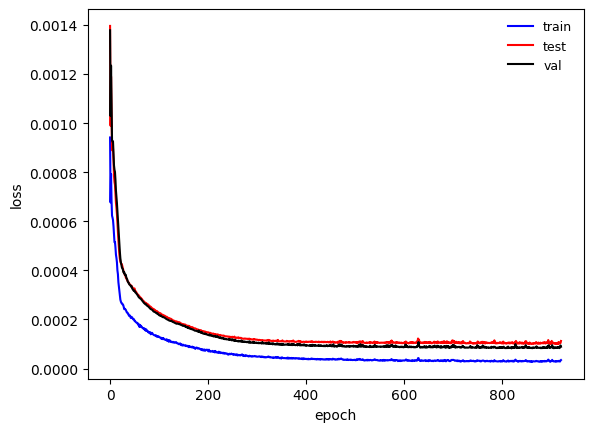

In [52]:
plt.figure()
start=0
plt.plot(train_losses[start:], 'b',label = 'train') 
plt.plot(test_losses[start:], 'r',label = 'test') 
plt.plot(val_losses[start:], 'k',label = 'val') 
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(fontsize=9,
           bbox_to_anchor=(1, 1),
           frameon=False)
plt.show()